### Тема: Регрессионный анализ: линейная по параметрам регрессионная модель общего вида

**Выполнил**: Лежнин Максим Витальевич (ПМ-31)

**Преподаватель**: Олейник Т.А., кафедра ВМ-1

###### Практическая работа № **12**, вариант № **7**

###### Осенний семестр, 2023 год

###### МИЭТ, Зеленоград

### Библиотеки

In [1]:
import numpy as np
import scipy
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn
from math import floor

В файле «Данные 12_1» приведены 30 двумерных выборок непрерывных случайных векторов. Выполните задания 1–4 для двумерной выборки, отобранной в соответствии с вашим вариантом.

In [2]:
# функция для обработки выборки
def parse_sample(sample):
    new_sample = []
    for elem in sample:
        new_sample.append(float(str(elem).replace(",", ".").replace("–", "-")))
    return np.array(new_sample)

In [3]:
# заготовка выборки
var = 7

data = pd.read_excel('Data_12_1.xlsx')
table = pd.DataFrame(data)

X = table[table.columns[1 + 3 * (var - 1)]].dropna()
Y = table[table.columns[2 + 3 * (var - 1)]].dropna()

X = parse_sample(X)
Y = parse_sample(Y)

sample_size = len(X)
sample = np.array([X, Y]).T

### Задание 1
Осуществите статистическую обработку двумерной выборки по следующему плану.
- Постройте диаграмму рассеивания и проанализируйте ее с точки зрения наличия и характера связи между компонентами выборочного вектора. Оправдано ли для описания зависимости использовать модель $Y = \beta_0 + \beta_1x + \beta_2x^2 + E$? Если вы считаете, что не оправдано, то для выполнения следующих заданий используйте иную линейную регрессионную модель общего вида (но обязательно отличную от модели, рассмотренной в практической работе № 11).
- Считая, что $M[Y|x] = \beta_0 + \beta_1x + \beta_2x^2$, найдите оценки параметров модели $y = \beta_0 + \beta_1x + \beta_2x^2$ (непосредственно по формулам, без использования специализированных функций языка программирования
Python).
- Нанесите график построенного в п. 2 уравнения регрессии на диаграмму рассеивания.

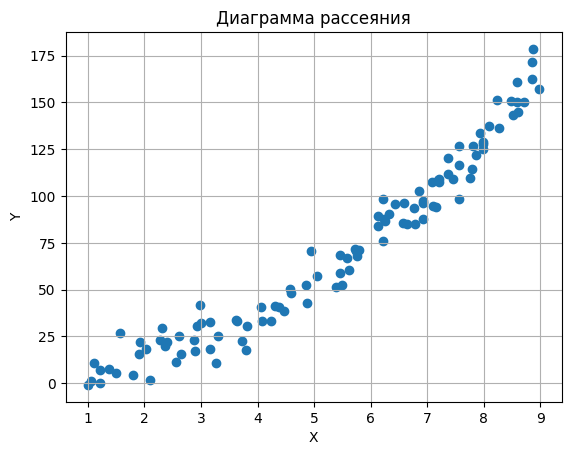

In [4]:
# строю диаграмму рассеяния
plt.scatter(X, Y)
plt.title("Диаграмма рассеяния")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

График похож на параболу, потому я считаю оправданным использовать модель $Y = \beta_0 + \beta_1x + \beta_2x^2 + E$. Для нахождения параметров $\beta_0,\, \beta_1,\, \beta_2$ воспользуюсь методом наименьших квадоратов.

In [5]:
# регрессионная матрица
def regr_matrix(X, dim):
    return np.array([np.array([X[j] ** i for i in range(dim)]) for j in range(len(X))])

# матрица (A^T * A)^{-1}
def useful_sq_matrix(A):
    return np.linalg.inv(np.matmul(A.T, A))

# расчет параметров регрессионной модели
def get_betas(Y, A):
    return np.matmul(np.matmul(useful_sq_matrix(A), A.T), Y)

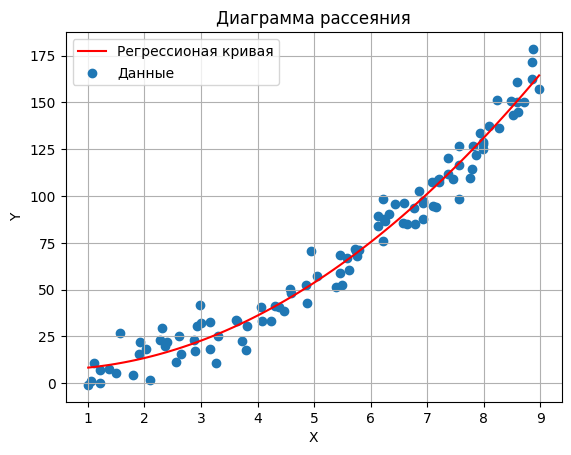

In [6]:
# получаю регрессионное уравнение
dim = 3
A = regr_matrix(X, dim)
beta = get_betas(Y, A)
regr_func = lambda x: sum(beta[i] * x ** i for i in range(dim))

# визуализирую данные и регрессионную кривую
x = np.linspace(min(X), max(X), 100)
plt.plot(x, regr_func(x), color="r", label="Регрессионая кривая")
plt.scatter(X, Y, label="Данные")
plt.title("Диаграмма рассеяния")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)

Похоже, регрессионная кривая действительно хорошо описывает данные и выбранная модель подходящая.

### Задание 2
В предположении, что ошибки наблюдений не коррелированы и имеют нормальное распределение $N(0,\, \sigma)$, оцените качество аппроксимации результатов наблюдения уравнением регрессии $y = \beta_0 + \beta_1x + \beta_2x^2$:
- проверьте значимость модели на уровне $\alpha = 0.05$;
- найдите точечные оценки дисперсии ошибок наблюдений и ковариационной матрицы;
- определите доверительные интервалы для параметров модели и дисперсии ошибок наблюдений при уровне значимости $\alpha = 0.05$.

In [7]:
# интервал для параметров модели
def beta_interval(n, k, A, err_var, alpha, beta, i):
    tmp = sts.t(n - k).ppf(1 - alpha / 2) * np.sqrt(err_var * A[i][i])
    return (beta - tmp, beta + tmp)

# интервал для дисперсии ошибок
def var_interval(n, k, err_var, alpha):
    tmp = (n - k) * err_var
    return(tmp/sts.chi2(n - k).ppf(1 - alpha / 2), tmp/sts.chi2(n - k).ppf(alpha / 2))

# сумма квадратов ошибок
def sum_of_sq_errors(X, Y, dim):
    A = regr_matrix(X, dim)
    beta = get_betas(Y, A)
    Q_r = np.matmul(np.matmul(beta.T, A.T), Y) - len(X) * Y.mean() ** 2
    Q_y = sum([(Y[i] - Y.mean())**2 for i in range(len(X))])
    return Q_y - Q_r

# дисперсия ошибок
def get_err_var(Q_e, sample_size, dim):
    return Q_e / (sample_size - dim)

In [8]:
# уровень значимости
alpha = 0.05

# сумма квадратов, обусловленная регрессией
Q_r = np.matmul(np.matmul(beta.T, A.T), Y) - sample_size * Y.mean() ** 2

# остаточная сумма квадратов
Q_e = sum_of_sq_errors(X, Y, dim)

# выборочное значение (статистика Фишера)
ssv = (Q_r / Q_e) * ((sample_size - dim) / (dim - 1))
print(f"Выборочное значение статистики: {ssv}")

# p-значение
pvalue = 2 * min(1-sts.f(dim - 1, sample_size - dim).cdf(ssv),
              sts.f(dim - 1, sample_size - dim).cdf(ssv))
print(f"Значение p: {pvalue}")

# проверка значимости
if alpha < pvalue:
    print("Наша модель незначима!")
else:
    print("Наша модель значима!")
print()

# оценка дисперсии ошибок
err_var = get_err_var(Q_e, sample_size, dim)
print(f"Оценка для дисперсии ошибок: {err_var}")

# оценка ковариационной матрицы
K = err_var * useful_sq_matrix(A)
print(f"Оценка ковариационной матрицы:\n{K}")
print()

# интервалы для параметров
for i in range(len(beta)):
    print(f"Интервал для бета {i}:")
    print(beta_interval(sample_size, dim, A, err_var, alpha, beta[i], i))

# интервал для дисперсии ошибок
print("Интервал для дисперсии ошибок:")
print(var_interval(sample_size, dim, err_var, alpha))

Выборочное значение статистики: 1889.9185588789305
Значение p: 2.220446049250313e-16
Наша модель значима!

Оценка для дисперсии ошибок: 63.131797226327265
Оценка ковариационной матрицы:
[[14.15745188 -5.89017227  0.52605993]
 [-5.89017227  2.80431007 -0.26705624]
 [ 0.52605993 -0.26705624  0.02645329]]

Интервал для бета 0:
(-8.407666044404555, 23.10859089880205)
Интервал для бета 1:
(-43.21590038383002, 41.10445759369337)
Интервал для бета 2:
(-45.19835586227723, 49.32887624472598)
Интервал для дисперсии ошибок:
(48.90085123805239, 84.65946210423421)


### Задание 3
Для изучения вопроса об адекватности построенной модели проанализируйте остатки (выборку значений случайных ошибок
наблюдений):
- постройте график остатков в зависимости от $x_j$, проанализуйте его;
- постройте гистограмму и проверьте гипотезу о распределении ошибок наблюдений по нормальному закону.

К каким выводам вы пришли?

p-значение по Шапиро: 0.7531400918960571


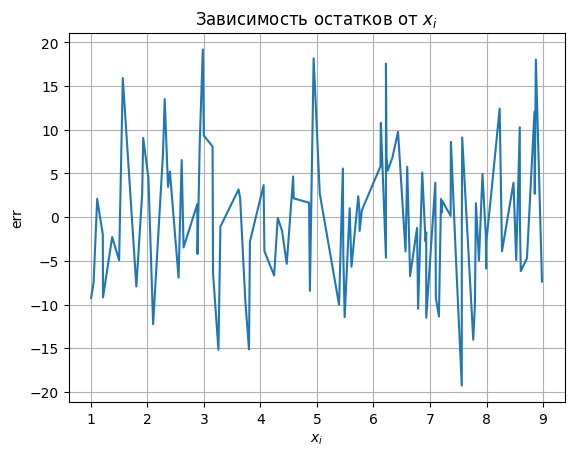

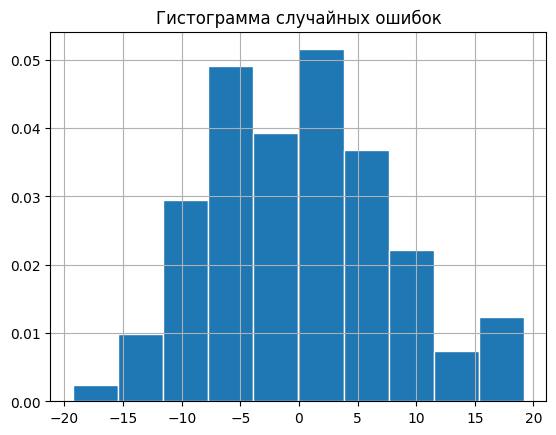

In [9]:
# выборка ошибок
error_sample = []
for i in range(sample_size):
    error_sample.append(Y[i] - regr_func(X[i]))

# график зависимости ошибок от x
sorted_errors = [x for _, x in sorted(zip(X, error_sample))]
plt.plot(sorted(X), sorted_errors)
plt.title("Зависимость остатков от $x_i$")
plt.xlabel("$x_i$")
plt.ylabel("err")
plt.grid(True)

# строю гистограмму
plt.figure()
plt.hist(error_sample, edgecolor='w', density=True)
plt.title(f"Гистограмма случайных ошибок")
plt.grid(True)

# критерий Шапиро-Уилка
shapiro_results = sts.shapiro(error_sample)

# выводим p-значения на экран
print(f"p-значение по Шапиро: {shapiro_results.pvalue}")

p-значение получилось достаточно большим, чтобы мы могли с уверенностью заявить о нормальности выборки случайных ошибок.

### Задание 4
Используйте для описания статистической зависимости компонент того же выборочного вектора модель $y = \beta_0 + \beta_1x$. Сопоставьте характеристики построенной регрессионной модели с характеристиками регрессионной модели задания $y = \beta_0 + \beta_1x + \beta_2x^2$. Интерпретируйте результаты.

Оценка для линейного уравнения: 160.40267442910465
Оценка для квадратного уравнения: 63.131797226327265
p-значение по Шапиро: 0.11975587904453278


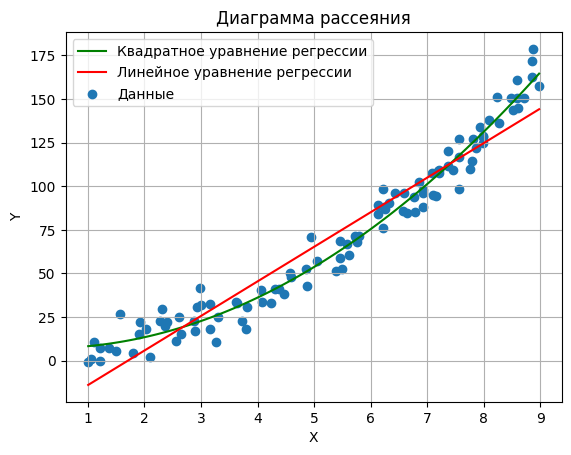

In [10]:
# получаю уравнение для новой модели
new_dim = 2
new_A = regr_matrix(X, new_dim)
new_beta = get_betas(Y, new_A)
new_regr_func = lambda x: sum(new_beta[i] * x ** i for i in range(new_dim))

# строю оба уравнения на диаграмме
x = np.linspace(min(X), max(X), 100)
plt.plot(x, regr_func(x), color="g", label="Квадратное уравнение регрессии")
plt.plot(x, new_regr_func(x), color="r", label="Линейное уравнение регрессии")
plt.scatter(X, Y, label="Данные")
plt.title("Диаграмма рассеяния")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)

# считаю оценку дисперсии и вывожу на экран обе оценки
new_Q_e = sum_of_sq_errors(X, Y, new_dim)
new_err_var = get_err_var(new_Q_e, sample_size, new_dim)
print(f"Оценка для линейного уравнения: {new_err_var}\n"
      f"Оценка для квадратного уравнения: {err_var}")

# проверяю адекватность новой модели
new_error_sample = []
for i in range(sample_size):
    new_error_sample.append(Y[i] - new_regr_func(X[i]))
    
# критерий Шапиро-Уилка
shapiro_results = sts.shapiro(new_error_sample)
print(f"p-значение по Шапиро: {shapiro_results.pvalue}")

Дисперсия ошибок у линейного уравнения сильно выше, что показывает нам, что квадратное уравнение точнее описывает зависимость двух переменных. Также я проверил линейное уравнение на адекватность и при привычных значениях $\alpha$ такая модель тоже будет адекватной. Однако p-значение получилось сильно ниже, что намекает на то, что линейное уравнение хуже предсказывает наблюдаемые значения. 